In [1]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import os
import pickle
import time
from tqdm.notebook import tqdm

import torch
torch.set_default_tensor_type(torch.DoubleTensor)

from spatial_scene_grammars.nodes import *
from spatial_scene_grammars.rules import *
from spatial_scene_grammars.scene_grammar import *
from spatial_scene_grammars.visualization import *
from spatial_scene_grammars_examples.gmm.grammar import *
from spatial_scene_grammars.parsing import *
from spatial_scene_grammars.sampling import *
from spatial_scene_grammars.parameter_estimation import *

GT rule probs:  tensor([0.4000, 0.4000, 0.2000], grad_fn=<DivBackward0>)
GT Mode 0: [-5. -5. -5.] +/- [0.5 0.5 0.5]
GT Mode 1: [5. 5. 5.] +/- [0.25 0.25 0.25]
GT Mode 2: [-2. -2. -2.] +/- [2. 2. 2.]
Pre-fit rule probs:  tensor([0.2995, 0.1439, 0.5566], grad_fn=<DivBackward0>)
Pre-fit Mode 0: [-3. -3. -3.] +/- [0.1 0.1 0.1]
Pre-fit Mode 1: [0. 0. 0.] +/- [0.1 0.1 0.1]
Pre-fit Mode 2: [3. 3. 3.] +/- [0.1 0.1 0.1]


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

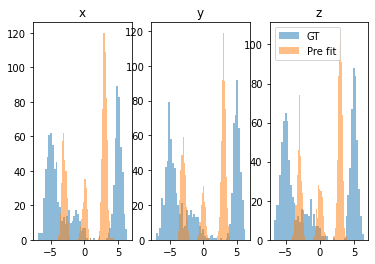

In [2]:
# Make the ground truth GMM grammar.
gt_grammar =SpatialSceneGrammar(
    root_node_type = Root,
    root_node_tf = torch.eye(4),
    sample_params_from_prior=True
)
# Reset params to values we control (different from prior).
desired_mode_means = [
    torch.tensor([-5., -5., -5.]),
    torch.tensor([5., 5., 5.]),
    torch.tensor([-2., -2., -2.])
]
desired_mode_vars = [
    torch.tensor([0.5, 0.5, 0.5]),
    torch.tensor([0.25, 0.25, 0.25]),
    torch.tensor([2., 2., 2.])
]
desired_mode_weights = torch.tensor([0.4, 0.4, 0.2])
rule_probs_param = gt_grammar.params_by_node_type[Root.__name__]
rule_probs_param.set(desired_mode_weights)
print("GT rule probs: ", rule_probs_param())
for k, mode in enumerate(Modes):
    mode_name = mode.__name__
    mean_param = gt_grammar.rule_params_by_node_type[mode_name][0][0]["mean"]
    mean_param.set(desired_mode_means[k])
    var_param = gt_grammar.rule_params_by_node_type[mode_name][0][0]["variance"]
    var_param.set(desired_mode_vars[k])
    print("GT Mode %d: %s +/- %s" % (k, mean_param().detach().numpy(), var_param().detach().numpy()))

# Make our fitting grammar. This'll also have randomly sampled means + vars, but
# different ones.
torch.random.manual_seed(2)
fit_grammar = SpatialSceneGrammar(
    root_node_type = Root,
    root_node_tf = torch.eye(4),
    sample_params_from_prior=True
)
#fit_grammar = deepcopy(gt_grammar)
pre_fit_grammar = deepcopy(fit_grammar)
rule_probs_param = pre_fit_grammar.params_by_node_type[Root.__name__]
print("Pre-fit rule probs: ", rule_probs_param())
for k, mode in enumerate(Modes):
    mode_name = mode.__name__
    mean_param = fit_grammar.rule_params_by_node_type[mode_name][0][0]["mean"]
    mean_param.set((torch.ones(3)*k - torch.ones(3)) * 3.)
    var_param = fit_grammar.rule_params_by_node_type[mode_name][0][0]["variance"]
    var_param.set(torch.ones(3) * 0.1)
    print("Pre-fit Mode %d: %s +/- %s" % (k, mean_param().detach().numpy(), var_param().detach().numpy()))


def get_all_node_xyzs(sampled_trees, node_type):
    l = []
    for tree in sampled_trees:
        for node in tree:
            if isinstance(node, node_type):
                l.append(node.translation.detach().cpu().numpy())
    return np.stack(l)

# Draw random samples from our randomly-initialized GMM
def get_draws_from_grammar(grammar, N_samples):
    samples = []
    for k in tqdm(range(N_samples)):
        tree = grammar.sample_tree(detach=True)
        observed_nodes = tree.get_observed_nodes()
        samples.append((tree, observed_nodes))
    return samples

gt_samples = get_draws_from_grammar(gt_grammar, 1000)
pre_fit_samples = get_draws_from_grammar(fit_grammar, 1000)
l_gt = get_all_node_xyzs([sample[0] for sample in gt_samples], Point)
l_pre_fit = get_all_node_xyzs([sample[0] for sample in pre_fit_samples], Point)
for k, label in enumerate("xyz"):
    plt.subplot(1, 3, k+1)
    plt.hist(l_gt[:, k], bins=50, label="GT", alpha=0.5)
    plt.hist(l_pre_fit[:, k], bins=50, label="Pre fit", alpha=0.5)
    plt.title(label)
    if k == 2:
        plt.legend()

  0%|          | 0/100 [00:00<?, ?it/s]

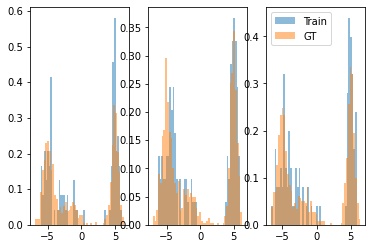

In [3]:
torch.random.manual_seed(43)
N_fit_samples = 100

# Draw an actual fitting dataset.
samples = get_draws_from_grammar(gt_grammar, N_fit_samples)

l_gt = get_all_node_xyzs([sample[0] for sample in gt_samples], Point)
l_train = get_all_node_xyzs([sample[0] for sample in samples], Point)
plt.figure()
for k, label in enumerate("xyz"):
    plt.subplot(1, 3, k+1)
    plt.hist(l_train[:, k], label="Train", alpha=0.5, bins=50, density=True)
    plt.hist(l_gt[:, k], label="GT", alpha=0.5, bins=50, density=True)
    if k == 2:
        plt.legend()

EM fit rule probs:  tensor([0.4700, 0.4302, 0.0998], grad_fn=<DivBackward0>)
EM-fit Mode 2: Parameter containing:
tensor([4.9917, 5.0070, 5.0496], requires_grad=True) +/- tensor([0.1947, 0.2344, 0.1816], grad_fn=<AddBackward0>)
EM-fit Mode 2: Parameter containing:
tensor([-4.2707, -4.5757, -4.2841], requires_grad=True) +/- tensor([2.1151, 0.7433, 1.9846], grad_fn=<AddBackward0>)
EM-fit Mode 2: Parameter containing:
tensor([-2.6013, -1.5080, -2.2698], requires_grad=True) +/- tensor([1.4390, 0.3470, 1.8269], grad_fn=<AddBackward0>)


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

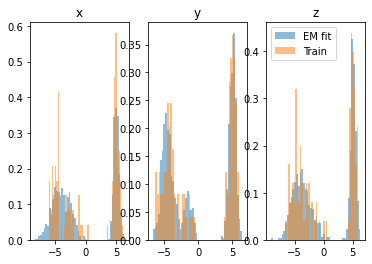

In [4]:
# Hand-written EM baseline for GMM: estimate cluster
# association weights, and then apply a closed form update
# to get new best cluster mean and vars. (Like a "soft"
# k-mean.)

# Initialize param guesses from pre-fit grammar
param_guesses = {
    "mode_weights": pre_fit_grammar.params_by_node_type[Root.__name__]().detach()
}
for mode in Modes:
    mode_name = mode.__name__
    mean = pre_fit_grammar.rule_params_by_node_type[mode_name][0][0]["mean"]().detach()
    var = pre_fit_grammar.rule_params_by_node_type[mode_name][0][0]["variance"]().detach()
    param_guesses[mode_name] = {
        "mean": mean,
        "var": var
    }

N_iters = 10
points = torch.stack([sample[1][0].translation for sample in samples]) # N x 3
for iter_k in range(N_iters):
    # Associate each sample with the MAP cluster
    dists = [
        dist.Normal(
            param_guesses[mode.__name__]["mean"],
            param_guesses[mode.__name__]["var"])
        for mode in Modes
    ]
    # Get scores for each mode for each point.
    point_log_probs = torch.stack([
        dist.log_prob(points).sum(axis=1) for dist in dists
    ], axis=-1) # N x N_dists
    # Multiply in prob of that cluster being active
    point_log_probs = point_log_probs + param_guesses["mode_weights"]
    # Normalize for a given point
    point_log_probs = (point_log_probs.T - torch.logsumexp(point_log_probs, axis=-1)).T
    w = torch.exp(point_log_probs)
    
    # New weight guesses are average of weights
    new_weights = torch.mean(w, axis=0) + 1E-4
    new_weights = new_weights / torch.sum(new_weights)
    param_guesses["mode_weights"] = new_weights
    # New mean is weighted sum of observed locations
    for k, mode in enumerate(Modes):
        new_mean = torch.sum(w[:, k] * points.T, axis=1) / torch.sum(w[:, k])
        offsets = points - new_mean
        new_var = torch.sum(w[:, k] * torch.square(offsets).T, axis=1) / torch.sum(w[:, k]) + 1E-4
        param_guesses[mode.__name__]["mean"] = new_mean
        param_guesses[mode.__name__]["var"] = new_var
# Make an EM-fit grammar with those params
em_fit_grammar = deepcopy(pre_fit_grammar)
rule_probs_param = em_fit_grammar.params_by_node_type[Root.__name__]
rule_probs_param.set(param_guesses["mode_weights"])
print("EM fit rule probs: ", rule_probs_param())
for mode in Modes:
    mode_name = mode.__name__
    mean_param = em_fit_grammar.rule_params_by_node_type[mode_name][0][0]["mean"]
    var_param = em_fit_grammar.rule_params_by_node_type[mode_name][0][0]["variance"]
    mean_param.set(param_guesses[mode_name]["mean"])
    var_param.set(param_guesses[mode_name]["var"])
    print("EM-fit Mode %d: %s +/- %s" % (k, mean_param(), var_param()))
    
# Draw its empirical fit
gt_samples = get_draws_from_grammar(gt_grammar, 1000)
em_fit_samples = get_draws_from_grammar(em_fit_grammar, 1000)
l_gt = get_all_node_xyzs([sample[0] for sample in gt_samples], Point)
l_em_fit = get_all_node_xyzs([sample[0] for sample in em_fit_samples], Point)
l_train = get_all_node_xyzs([sample[0] for sample in samples], Point)
for k, label in enumerate("xyz"):
    plt.subplot(1, 3, k+1)
    #plt.hist(l_gt[:, k], bins=100, label="GT", alpha=0.5, density=True)
    plt.hist(l_em_fit[:, k], bins=50, label="EM fit", alpha=0.5, density=True)
    plt.hist(l_train[:, k], bins=50, label="Train", alpha=0.5, density=True)
    plt.title(label)
    if k == 2:
        plt.legend()

# One-shot parsing with MAP point latent estimates

In [8]:
# Do single-shot fitting of grammar params based on just the optimal parses
# Use SVI wrapper to collect MAP trees (maybe this should be split out)
one_shot_fit_grammar = deepcopy(pre_fit_grammar)
em = EMWrapper(one_shot_fit_grammar, [sample[1] for sample in samples])
em.do_iterated_em_fitting(em_iterations=5, tqdm=tqdm, N_solutions=3);

EM Iteration:   0%|          | 0/5 [00:00<?, ?it/s]

Getting MAP parses:   0%|          | 0/100 [00:00<?, ?it/s]

Getting MAP parses:   0%|          | 0/100 [00:00<?, ?it/s]

Getting MAP parses:   0%|          | 0/100 [00:00<?, ?it/s]

Getting MAP parses:   0%|          | 0/100 [00:00<?, ?it/s]

Getting MAP parses:   0%|          | 0/100 [00:00<?, ?it/s]

Final params:  tensor([0.4700, 0.3862, 0.1438])


GaussianMode_0 :
0:xyz:mean final: tensor([4.9917, 5.0070, 5.0496])
0:xyz:variance final: tensor([0.1946, 0.2343, 0.1815])
GaussianMode_1 :
0:xyz:mean final: tensor([-4.5966, -4.6660, -4.5978])
0:xyz:variance final: tensor([1.3523, 0.7746, 1.1170])
GaussianMode_2 :
0:xyz:mean final: tensor([-2.2365, -2.2040, -2.0431])
0:xyz:variance final: tensor([1.2058, 1.2686, 1.7355])


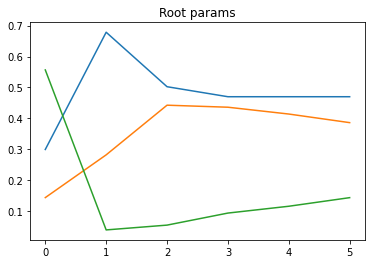

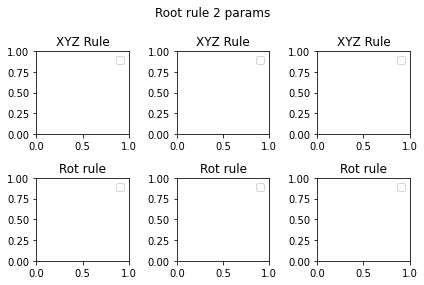

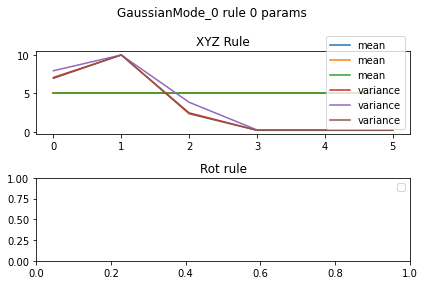

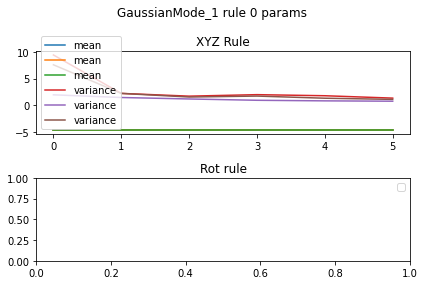

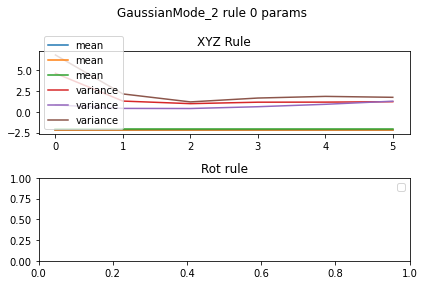

In [10]:
em.plot_grammar_parameter_history(Root)
for mode in Modes:
    print(mode.__name__, ":")
    em.plot_grammar_parameter_history(mode)

One shot fit rule probs:  tensor([0.4700, 0.4361, 0.0939], grad_fn=<DivBackward0>)
One shot-fit Mode 2: Parameter containing:
tensor([4.9917, 5.0070, 5.0496], requires_grad=True) +/- tensor([0.1948, 0.2345, 0.1816], grad_fn=<AddBackward0>)
One shot-fit Mode 2: Parameter containing:
tensor([-4.3051, -4.5107, -4.3342], requires_grad=True) +/- tensor([2.0001, 0.9481, 1.7342], grad_fn=<AddBackward0>)
One shot-fit Mode 2: Parameter containing:
tensor([-2.3376, -1.6184, -1.9115], requires_grad=True) +/- tensor([1.1485, 0.6040, 1.6483], grad_fn=<AddBackward0>)


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

[[-1.62166304 -4.01872533 -2.56024103]
 [-1.42717021 -1.96776287 -2.92678255]
 [ 5.5287041   5.53201249  4.9188044 ]
 ...
 [-3.08006661 -3.43572498 -8.6118316 ]
 [-2.92205675 -1.53974673 -1.04861931]
 [ 5.56958773  4.60373401  5.24823859]]


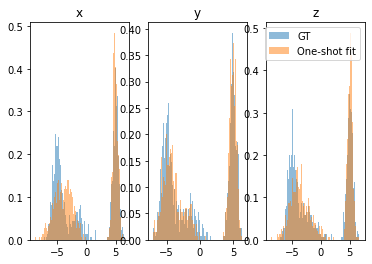

In [212]:
rule_probs_param = one_shot_fit_grammar.params_by_node_type[Root.__name__]
print("One shot fit rule probs: ", rule_probs_param())
for mode in Modes:
    mode_name = mode.__name__
    mean_param = one_shot_fit_grammar.rule_params_by_node_type[mode_name][0][0]["mean"]
    var_param = one_shot_fit_grammar.rule_params_by_node_type[mode_name][0][0]["variance"]
    print("One shot-fit Mode %d: %s +/- %s" % (k, mean_param(), var_param()))
    
gt_samples = get_draws_from_grammar(gt_grammar, 1000)
fit_samples = get_draws_from_grammar(one_shot_fit_grammar, 1000)
l_gt = get_all_node_xyzs([sample[0] for sample in gt_samples], Point)
l_fit = get_all_node_xyzs([sample[0] for sample in fit_samples], Point)
print(l_fit)
l_train = get_all_node_xyzs([sample[0] for sample in samples], Point)
plt.figure()
for k, label in enumerate("xyz"):
    plt.subplot(1, 3, k+1)
    plt.hist(l_gt[:, k], bins=100, label="GT", alpha=0.5, density=True)
    plt.hist(l_fit[:, k], bins=100, label="One-shot fit", alpha=0.5, density=True)
    plt.title(label)
    if k == 2:
        plt.legend()

# MLE gradient-descent parsing with point latent estimates

In [213]:
# Do MLE via gradient descent
svi = SVIWrapper(fit_grammar, [sample[1] for sample in samples])
svi.do_iterated_vi_fitting(major_iterations=1, minor_iterations=200, base_lr=0.01, subsample=None, tqdm=tqdm, clip=None, N_solutions=3)

Major iteration:   0%|          | 0/1 [00:00<?, ?it/s]

Getting MAP parses:   0%|          | 0/100 [00:00<?, ?it/s]

Minor iteration:   0%|          | 0/200 [00:00<?, ?it/s]

Fit mode probs:  tensor([0.4499, 0.0802, 0.4699], grad_fn=<DivBackward0>)
Mode  <class 'spatial_scene_grammars_examples.gmm.grammar.GaussianMode_0'>
0:xyz:mean final: tensor([-4.3564, -4.2924, -4.3300])
0:xyz:variance final: tensor([0.8505, 0.9036, 0.8342])


Mode  <class 'spatial_scene_grammars_examples.gmm.grammar.GaussianMode_1'>
0:xyz:mean final: tensor([-1.5204, -1.9649, -1.1845])
0:xyz:variance final: tensor([1.0191, 1.0422, 0.9946])


Mode  <class 'spatial_scene_grammars_examples.gmm.grammar.GaussianMode_2'>
0:xyz:mean final: tensor([4.9325, 4.9277, 4.9746])
0:xyz:variance final: tensor([0.3127, 0.3534, 0.3232])


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

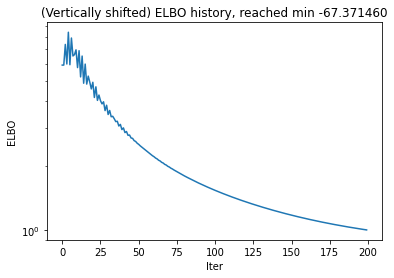

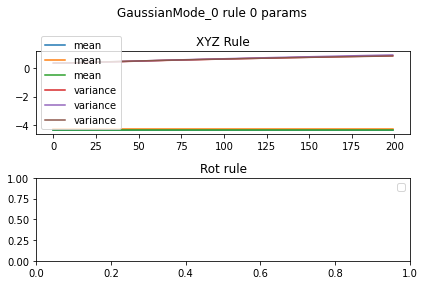

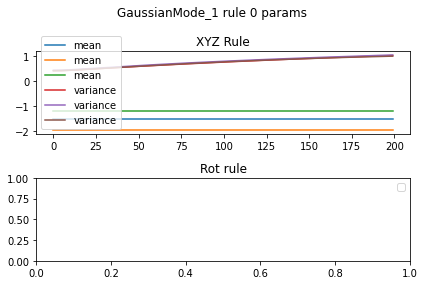

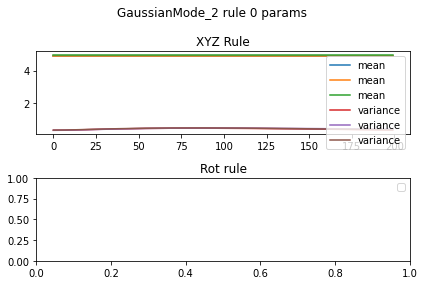

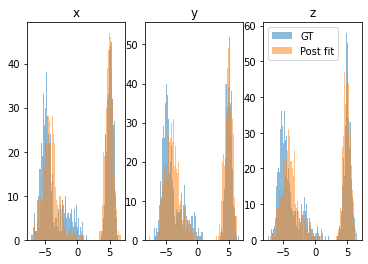

In [214]:
svi.plot_elbo_history()
print("Fit mode probs: ", fit_grammar.params_by_node_type[Root.__name__]())
for mode in Modes:
    print("Mode " , mode)
    svi.plot_grammar_parameter_history(mode)
gt_samples = get_draws_from_grammar(gt_grammar, 1000)
fit_samples = get_draws_from_grammar(fit_grammar, 1000)
l_gt = get_all_node_xyzs([sample[0] for sample in gt_samples], Point)
l_fit = get_all_node_xyzs([sample[0] for sample in fit_samples], Point)
l_train = get_all_node_xyzs([sample[0] for sample in samples], Point)
plt.figure()
for k, label in enumerate("xyz"):
    plt.subplot(1, 3, k+1)
    #plt.hist(l_train[:, k], label="Train", alpha=0.25)
    plt.hist(l_gt[:, k], bins=100, label="GT", alpha=0.5)
    plt.hist(l_fit[:, k], bins=100, label="Post fit", alpha=0.5)
    plt.title(label)
    if k == 2:
        plt.legend()